# 3.3.4 - XGBoost - Boosting - Método Ensemble.


* En este Notebook vamos ***resolver un problema de clasificación usando la librería XGBoost*** que es una de las librerías más populares en los último tiempos debido al gran exito que esta teniendo en las competiciones de Kaggle.


* Vamos a tratar los siguientes puntos:
<span></span><br>
    1. [XGBoost](#M1)
<span></span><br>
    2. [Ejemplo de Predicción de Churn (Clasificación)](#M2)
    <span></span><br>
        2.1. [Carga de datos](#M21)
    <span></span><br>
        2.2. [Preparación de los datos y Particionado de datos en Entrenamiento y Test](#M22)
    <span></span><br>
        2.3. [Visualización de los datos](#M23)
    <span></span><br>
        2.4. [Creacción y ajuste del meta-modelo](#M24)
    <span></span><br>
        2.5. [Visualización del Árbol de Decisión e importancia de las Variables](#M25)
    <span></span><br>
        2.6. [Evaluación del meta-modelo](#M26)
    <span></span><br>
        2.7. [Conclusiones](#M27)


<hr>



## <a name="M1">1. XGBoost</a>


* "***XGBoost***" es una librería que tiene implementada el ***Gradient Boosting*** (Método Ensemble de Boosting) de manera muy eficiente, flexible, portable y optimizada para la ejecución en distribuido, lo que hace a esta librería muy apropiada para resolver problemas de Regresión y/o Clasificación cuando se trabaja con muchos datos.


* La documentación de esta librería se puede encontrar en: https://xgboost.readthedocs.io/


* Esta librería no solo goza de gran popularidad debido a los buenos resultados que ofrece para la resolución de problemas reales, si no que también es debido al gran uso que se le esta dando en la competiciones de Kaggle.


* A parte de implementar el ***Gradient Boosting*** para la resolución de problemas de Regresión y/o Clasificación tambien ofrece otra serie de funcionalidades relacionadas con el tratamiento de los datos, visualizaciones, etc. lo que hace a esta librería muy potente no solo en el ámbito de las predicciones.

<hr>


## <a name="M2">2. Ejemplo de Predicción de Churn (Clasificación)</a>


* En el siguiente ejemplo vamos a resolver un problema de predicción de Churn; es decir, tenemos que clasificar (predecir) que clientes que hacen uso de los servicios de una determinada empresa se darán de baja de sus servicios.


* Para realizar este ejercicio usaremos la librería XGBoost y en particular su módulo de clasificación "**XGBClassifier()**"


* De la misma manera se pueden resolver también problemas de regresión con la clase "**XGBRegressor()**".


* En la siguiente enlace se encuentra la documentación a su API de Python:<br>https://xgboost.readthedocs.io/en/latest/python/python_api.html


* Tratar en detalle esta librería llevaría muchas horas de documentación y estudio, pero por hacer una aproximación simple a esta librería podemos usarlar de manera muy similar a la librería de scikit-learn ya que tambien implementa los métodos de '*fit()*' y '*predict()', para el ajuste del modelo y predicción respectivamente.


* Para realizar el problema de predicción del Churn vamos a tener las siguientes variables de los clientes:

    + **CustomerId**: Unique Ids for bank customer identification
    + **Surname**: Customer's last name
    + **CreditScore**: Credit score of the customer
    + **Geography**: The country from which the customer belongs
    + **Gender**: Male or Female
    + **Age**: Age of the customer
    + **Tenure**: Number of years for which the customer has been with the bank
    + **Balance**: Bank balance of the customer
    + **NumOfProducts**: Number of bank products the customer is utilising
    + **HasCrCard**: Binary Flag for whether the customer holds a credit card with the bank or not
    + **IsActiveMember**: Binary Flag for whether the customer is an active member with the bank or not
    + **EstimatedSalary**: Estimated salary of the customer in Dollars
    + **Exited**: Binary flag 1 if the customer closed account with bank and 0 if the customer is retained


* Para resolver este problema vamos a realizar los siguientes pasos:
<span></span><br>
    2.1. [Carga de datos](#M21)
<span></span><br>
    2.2. [Preparación de los datos y Particionado de datos en Entrenamiento y Test](#M22)
<span></span><br>
    2.3. [Visualización de los datos](#M23)
<span></span><br>
    2.4. [Creacción y ajuste del meta-modelo](#M24)
<span></span><br>
    2.5. [Visualización del Árbol de Decisión e importancia de las Variables](#M25)
<span></span><br>
    2.6. [Evaluación del meta-modelo](#M26)
<span></span><br>
    2.7. [Conclusiones](#M27)


* En primer lugar vamos a importar las librería necesarias:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from xgboost import XGBClassifier, plot_tree, plot_importance
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

<hr>


### <a name="M21">2.1. Carga de datos</a>

* El primer paso que vamos a realizar es el de cargar los datos que los tenemos en el siguiente fichero:
    - ***DataSet***: "../../data/Churn_Modelling.csv"

In [2]:
df = pd.read_csv("../../data/Churn_Modelling.csv")
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8065,8066,15690829,Sandefur,430,Germany,Male,49,3,137115.16,1,1,0,146516.86,1
4544,4545,15758081,Repina,673,Spain,Male,39,8,138160.00,1,1,1,110468.51,0
5721,5722,15643671,Chiekwugo,696,Germany,Male,49,5,97036.22,2,1,0,152450.84,1
3708,3709,15679983,Garmon,565,France,Male,34,7,0.00,1,0,0,74593.84,0
5897,5898,15709604,McMillan,781,France,Male,23,2,107433.48,1,1,0,173843.21,0


<hr>


### <a name="M22">2.2. Preparación de los datos y Particionado de datos en Entrenamiento y Test</a>


* Dado el Dataset y una vez eliminadas variables identificativas como el 'CustomerId' y el 'Surname' podemos observar como tenemos dos variables 'Geography' y 'Gender' que son dos variables que en principio parecen útiles pero son son variables cualitativas nominales por lo que vamos a tener que codificarlas con un One-Hot-Encode y un Binary-Encode respectivamente.


* En primer lugar vamos a seleccionar las variables que nos interesan:

In [3]:
X_features = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 
               'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
y_feature = ['Exited']
df = df[X_features + y_feature]
df.sample(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7563,609,France,Male,53,7,0.00,2,0,1,52332.85,0
8117,624,Spain,Female,34,6,0.00,1,1,0,582.59,1
4459,672,Germany,Female,23,10,110741.56,1,1,0,80778.50,0


* Pasamos a binaria la variable genero

In [4]:
lb = LabelBinarizer()
df['Gender'] = lb.fit_transform(df['Gender'])
df.sample(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4415,764,France,0,24,0,0.00,2,1,0,88724.49,0
5715,806,France,1,31,9,0.00,2,0,1,140168.36,0
3675,727,France,1,32,1,59271.82,1,1,1,46019.43,0


* Codificamos la variable 'Geography' con un One-Hot-Encode y mostramos el Datset resultante.

In [5]:
df_dummy = pd.get_dummies(df['Geography'])
df = pd.concat([df, df_dummy], axis=1)
df = df.drop(['Geography'], 1)
df.sample(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
874,645,0,38,5,101430.30,2,0,1,4400.32,0,1,0,0
1329,743,0,40,6,0.00,1,1,0,28280.80,1,1,0,0
1021,485,1,32,6,102238.01,2,1,1,194010.12,0,0,0,1


* Seleccionamos los datos y los dividimos en entrenamiento y test

In [6]:
y = df['Exited'].values
X = df.drop(y_feature, 1).values

# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<hr>


### <a name="M23">2.3. Visualización de los datos</a>

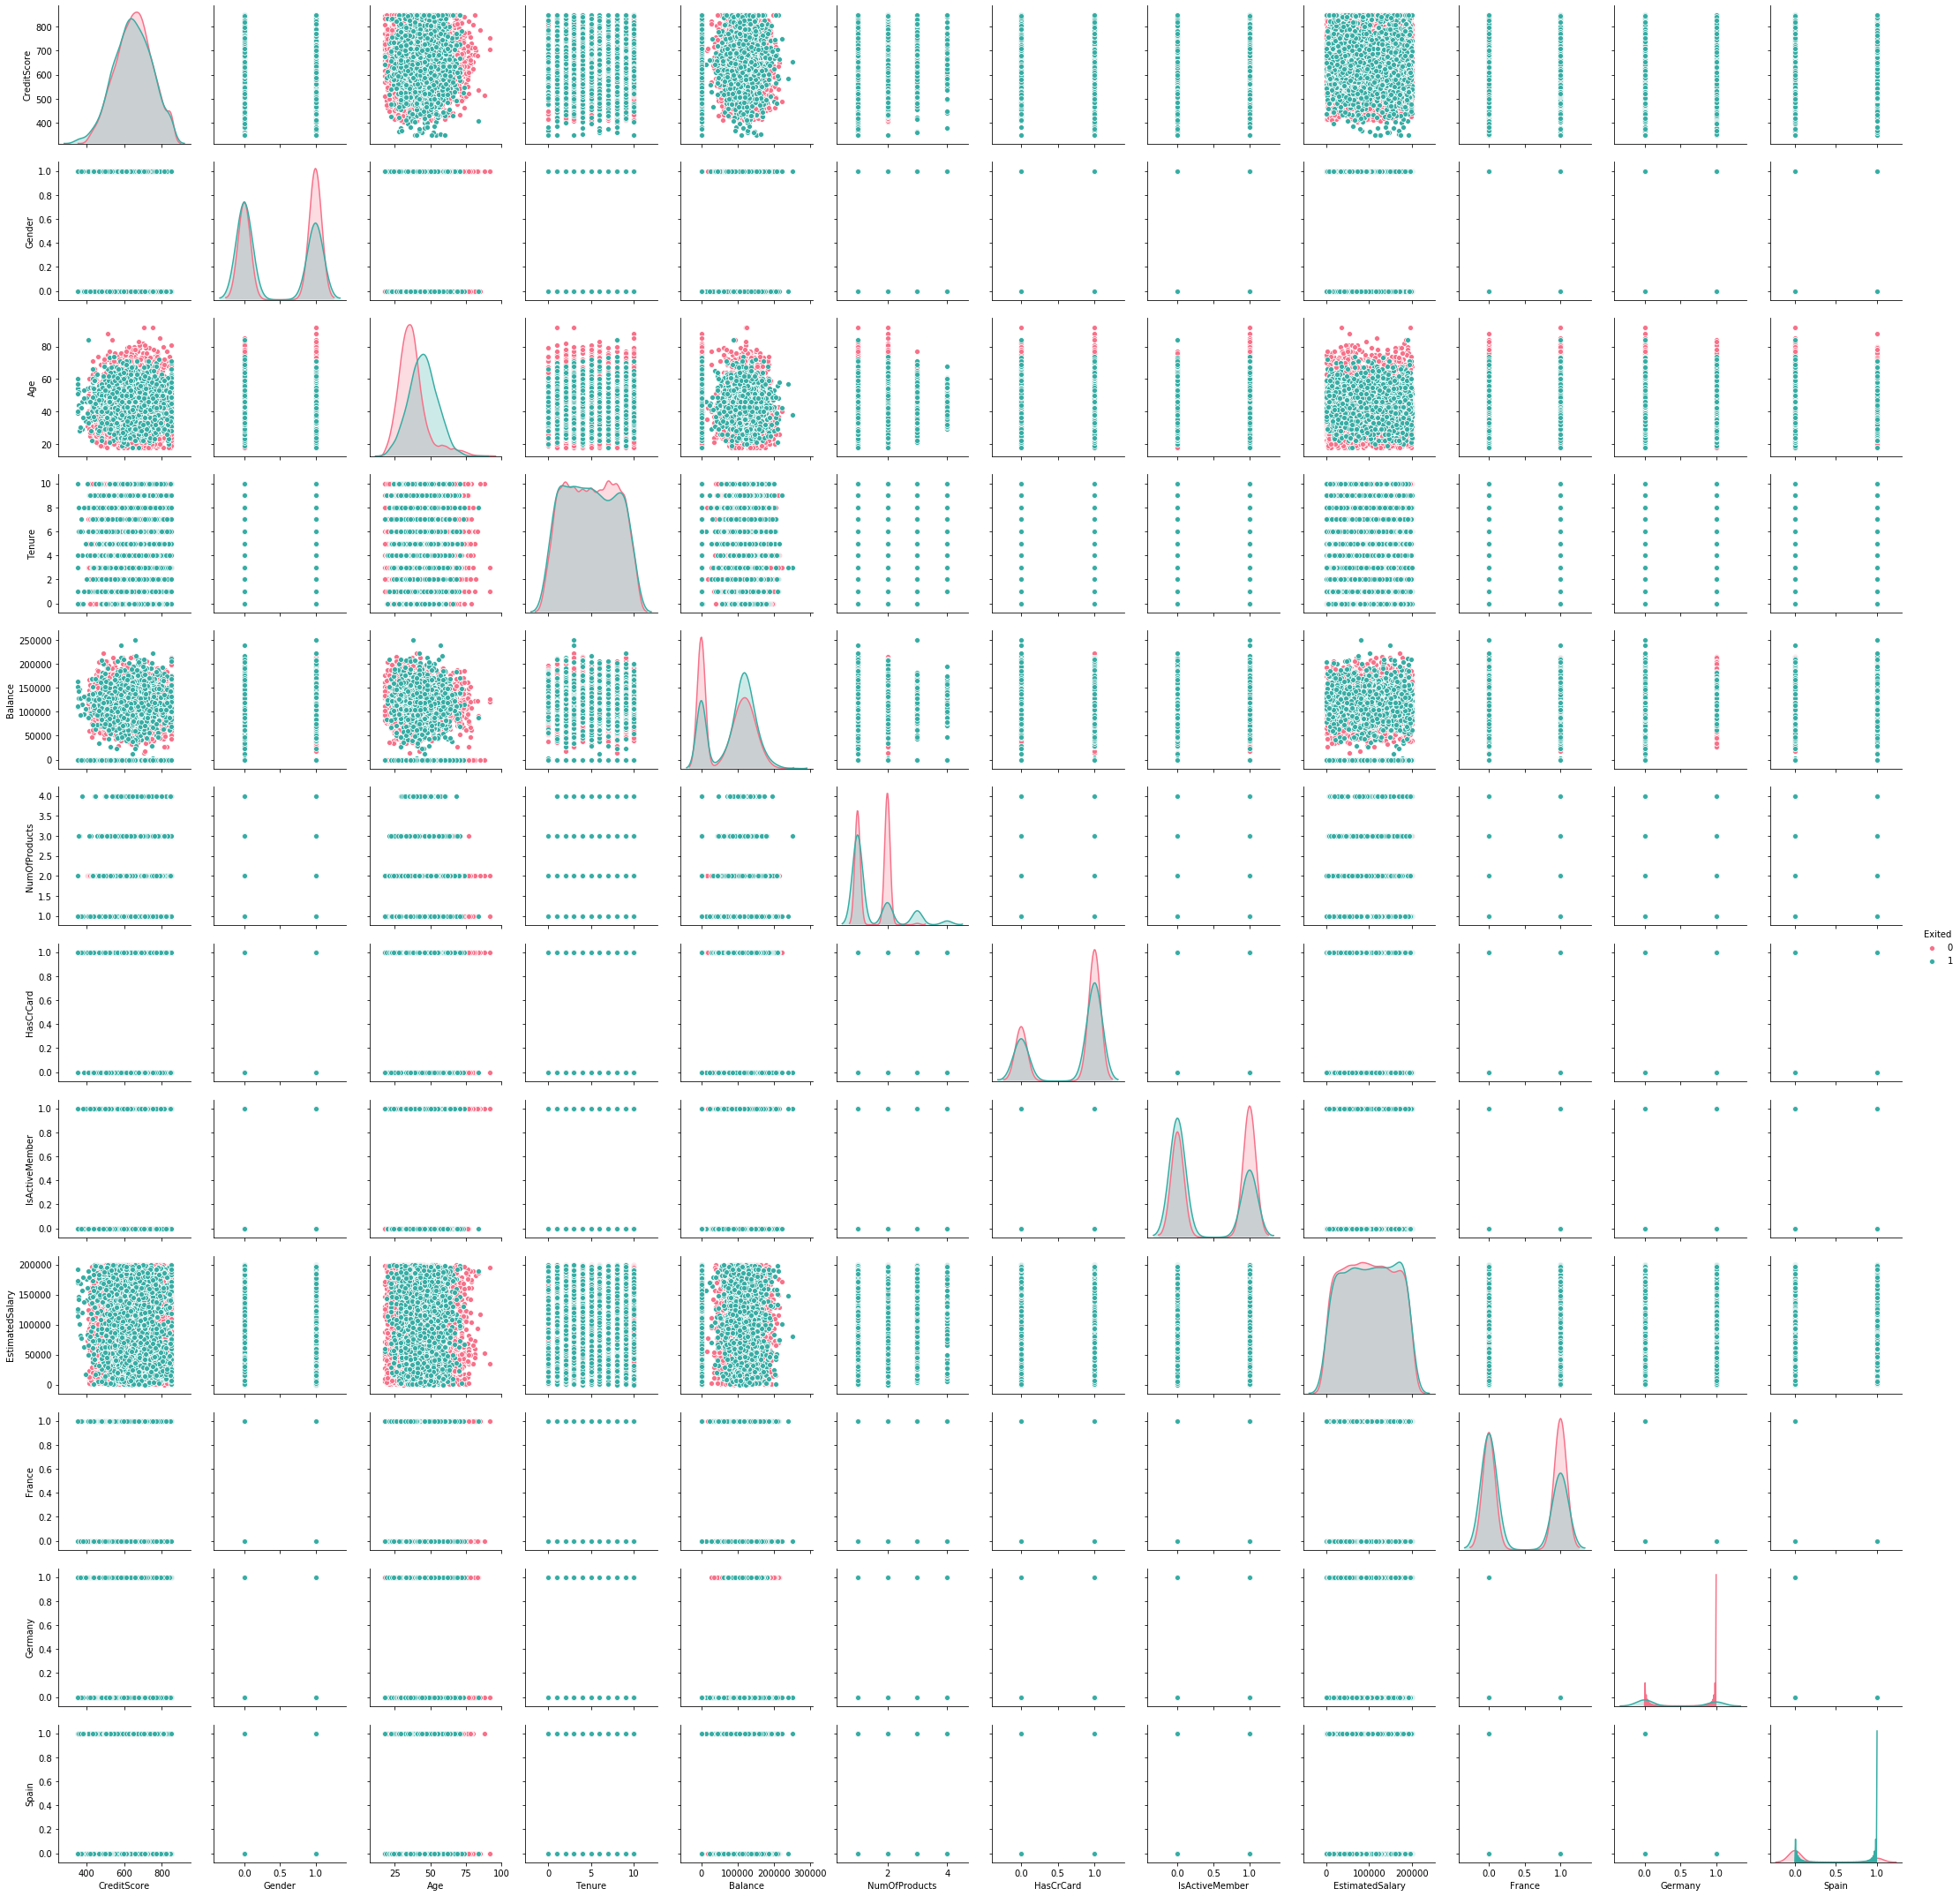

In [7]:
sns.pairplot(df, hue="Exited", palette="husl", vars=df.drop(y_feature, 1).columns)

<hr>


### <a name="M24">2.4. Creacción y ajuste del meta-modelo</a>


* Para ajustar el modelo vamos a instanciar un objeto de la clase '*XGBClassifier()*'.


* El constructor de esta clase nos permite pasarle una serie de parámetros de los cuales vamos a destacar los siguientes:

    + ***booster***: Especifica el booster a utilizar. Por defecto el gbtree
    + ***max_depth***: Especifica la profundidad de los árboles
    + ***scale_pos_weight***: Especifica el peso que le da a las clases positivas respecto de las negativas.


* En el ejemplo que estamos desarrollando tenemos los datos desbalanceados. Esto quiere decir que tenemos muchos más elementos de una clase que de otra por lo que en estos casos los Algortimos de Aprendizaje tenderán a aprender más de la clase que más elementos tenga que de la otra.


* Cuando tenemos el problema de los datos desbalanceados una buena técnica es la de dar más peso a aquellos elementos de la clase que esta en minoría (pasar 'n' veces los elementos de la clase que esta en minoría al Algoritmo de Aprendizaje). De esta manera daremos algo más de peso a la clase desbalanceada.


* Para estos casos XGBoost nos ayuda a trabajar con Datasets desbalanceados al permitirnos pasarle como parámetro el peso que le daremos a los elementos de la clase positiva a través del parámetro *scale_pos_weight*.


* Una regla cuando se trabaja con datos desbalanceados, es fijar el parámetro "scale_pos_weight" (Equilibrio de pesos positivos y negativos) con el valor de Nº Elementos positivos / Nº Elementos Negativos e ir probando como clasifica las clases que están en minoría. En este ejemplo y tras realizar algunas pruebas se decide poner con peso '2' a la clase de los clientes que abandonan los servicios de la compañia.

In [8]:
xgb_model = XGBClassifier(booster='gbtree', max_depth=3, scale_pos_weight=2, random_state=0)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=2,
              seed=None, silent=True, subsample=1)

<hr>


### <a name="M25">2.5. Visualización del Árbol de Decisión e importancia de las Variables</a>


* Una vez creado el meta-modelo, XGBoost nos proporciona las herramientas necesarias para poder visualizar los datos, entre otros como quedaría el arbol de decisión resultante:


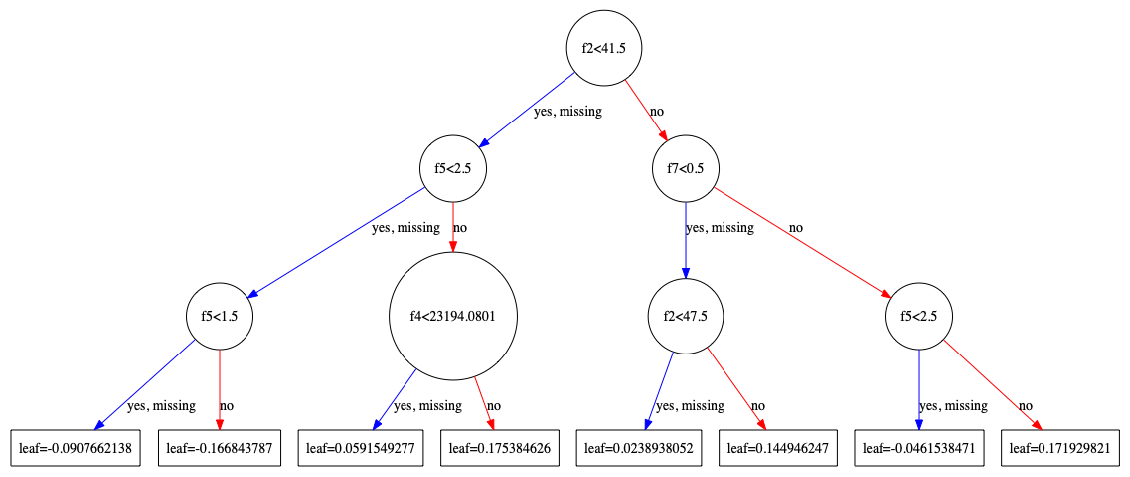

In [9]:
fig, ax = plt.subplots(figsize=(20, 16))
plot_tree(xgb_model, num_trees=0, ax=ax)
plt.show()

* Tambien nos ofrece información de la importancia de las variables:

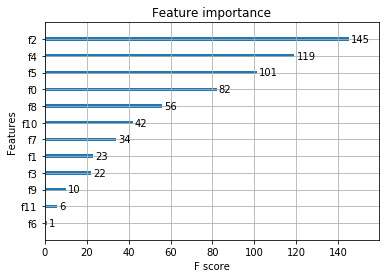

In [10]:
plot_importance(xgb_model)
plt.show()

<hr>


### <a name="M26">2.6. Evaluación del meta-modelo</a>

* Para cada uno de los árboles de la colección y para el AdaBoost vamos a calcular las siguientes métricas de evaluación:

    + Accuracy
    + F1
    + Precision
    + Recall
    + AUC_ROC

In [11]:
def evaluation(model, name, X_train, y_train, X_test, y_test):
    """
    Función de devuelve en un diccionario las métricas de evaluación de 
    Accuracy, Precision, Recall, F1 y AUC_ROC para los conjuntos de datos de entrenamiento y test
        model: modelo a evaluar
        name: nombre del modelo
        X_train: Variables de entrada del conjunto de datos de entrenamiento
        y_train: Variable de salida del conjunto de datos de entrenamiento
        X_test: Variables de entrada del conjunto de datos de test
        y_test: Variable de salida del conjunto de datos de test
        return: diccionario con el nombre del modelo y el valor de las métricas
    """
    model_dict = {}
    model_dict['name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_prob_train = model.predict_proba(X_train)
    y_prob_test = model.predict_proba(X_test)
    model_dict['accuracy_train'] = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['accuracy_tests'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['precision_train'] = precision_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['precision_tests'] = precision_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['recall_train'] = recall_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['recall_tests'] = recall_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['f1_train'] = f1_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['f1_tests'] = f1_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['auc_roc_train'] = roc_auc_score(y_true=y_train, y_score=y_prob_train[:, 1])
    model_dict['auc_roc_tests'] = roc_auc_score(y_true=y_test, y_score=y_prob_test[:, 1])
    
    return model_dict

df = pd.DataFrame.from_dict([evaluation(model=xgb_model, name='xgboost', 
                                        X_train=X_train, y_train=y_train, 
                                        X_test=X_test, y_test=y_test)])
df.set_index("name", inplace=True)
df

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests,auc_roc_train,auc_roc_tests
name,,,,,,,,,,
xgboost,0.8635,0.8495,0.679045,0.625,0.627451,0.641975,0.652229,0.633374,0.884923,0.87427


* A continuación mostramos la matriz de confusión para los datos de entrenamiento y test

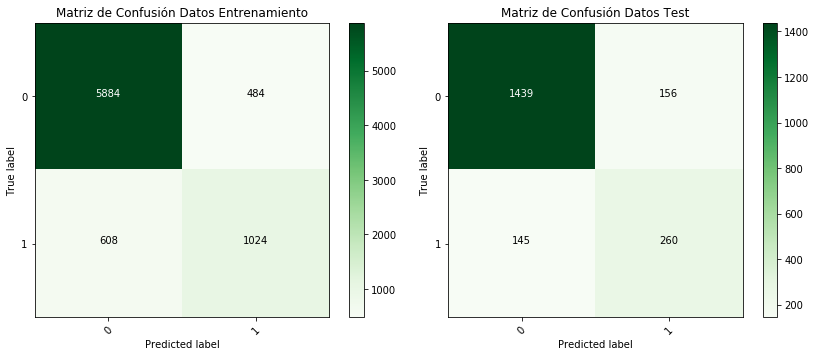

In [12]:
# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Obtenemos las matrices de confusión
cfm_train = confusion_matrix(y_true=y_train, y_pred=xgb_model.predict(X_train))
cfm_test = confusion_matrix(y_true=y_test, y_pred=xgb_model.predict(X_test))

# Pintamos las matrices de confusión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cfm_train, classes=['0', '1'], title='Matriz de Confusión Datos Entrenamiento')
plt.subplot(1, 2, 2)
plot_confusion_matrix(cfm_test, classes=['0', '1'], title='Matriz de Confusión Datos Test')
plt.show()

<hr>


### <a name="M27">2.7. Conclusiones</a>


* Dado que no hemos comparado los resultados de XGBoost con otro modelo, no podemos concluir que los resultados en la predicción son buenos o malos.


* Lo que si que podemos concluir es que los valores que obtenemos de las métricas de evaluación son bastante similares entre entrenamiento y test, con lo cual parece que el meta-modelo obtenido generaliza bastante bien sin caer el Overfitting.

<hr>


Este Notebook ha sido desarrollado por **Ricardo Moya García** y registrado en Safe Creative como ***Atribución-NoComercial-CompartirIgual***.


<img src="../../imgs/CC_BY-NC-SA.png" alt="CC BY-NC">